## Ways to Quantify Expressiveness from the Decision Boundary

1.  **Counting Linear (or Affine) Regions**
    *   **What:** For piecewise (affine) models like ReLU networks, the number of distinct linear regions the decision function splits space into.
    *   **Why:** More regions → more "breaks"/"bends" in the boundary → greater expressiveness.
    *   **How:**
        *   Exact counting is computationally hard for large nets, but tractable in low dimension or for small nets.
        *   Reference: Montúfar et al., 2014; Serra et al., 2018.
        *   There are open-source tools that can do this for small networks.
    *   **Use:** Compare two networks—the one with more regions is (all else equal) more expressive.

2.  **Decision Boundary Length (2D) or Surface Area (Higher d)**
    *   **What:** Compute the length of the boundary curve (in 2D) or surface area (in 3D+) separating classes.
    *   **Why:** More expressive models can create longer (more convoluted) boundaries.
    *   **How (practically in 2D):**
        *   Sample a fine grid.
        *   Extract the boundary as a set of points (e.g., by looking where the predicted class changes).
        *   Estimate total curve length by summing segment distances along the curve.
        *   See also Decision Boundary Complexity from Cavalcanti et al., 2018.
    *   **Use:** Compare models numerically—the longer the boundary, the more intricate.

3.  **Curvature Measures**
    *   **What:** How "bendy" is the boundary? High total (integrated) curvature = more turns and complexity.
    *   **How:**
        *   On a grid, approximate the boundary as a collection of points/segments and estimate local curvature.
        *   Integrate (sum) the curvature along the boundary.
    *   **Use:** Especially relevant for networks with smooth nonlinearities, e.g., KAN, tanh, etc.

4.  **Fractal Dimension of the Boundary (for highly expressive models)**
    *   **What:** For very irregular boundaries, the fractal dimension quantifies self-similarity and complexity at many scales.
    *   **How:** Box-counting or related algorithms.
    *   **References:** See, e.g., Fractal dimension of decision boundaries.
    *   **Use:** High fractal dimension = very high expressiveness.

5.  **Empirical Complexity on Synthetic Data**
    *   **What:** Use challenging synthetic benchmarks (moons, spirals, etc.), train your models, and compare the error rate: who can fit the most complicated boundary?
    *   **Why:** Not a geometric measure, but a proxy for expressiveness.

| Method                      | What is Quantified       | Works for ReLU? | Works for KAN? | Relative Difficulty |
|-----------------------------|--------------------------|-----------------|----------------|---------------------|
| Linear regions              | Piecewise regions        | Yes             | Limited        | Med-hard (exact)    |
| Boundary length/surface     | Complexity of boundary  | Yes             | Yes            | Easy                |
| Curvature                   | Bendiness                | Yes             | Yes            | Med                 |
| Fractal dimension           | Self-similarity          | Yes             | Yes            | Hard                |

In [9]:
import torch
import torch.nn as nn

class ReLUMLP(nn.Module):
    def __init__(self, n_hidden=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, 1)
        )
    def forward(self, x):
        return self.net(x)

class Spline1D(nn.Module):
    def __init__(self, n_knots=10, xmin=-2.0, xmax=3.0):
        super().__init__()
        self.n_knots = n_knots
        self.xmin = xmin
        self.xmax = xmax
        self.knots = nn.Parameter(torch.linspace(xmin, xmax, n_knots), requires_grad=False)
        self.values = nn.Parameter(torch.rand(n_knots))
    def forward(self, x):
        x = torch.clamp(x, self.xmin, self.xmax)
        idx_f = (x - self.xmin) / (self.xmax - self.xmin) * (self.n_knots - 1)
        idx0 = torch.floor(idx_f).long()
        idx1 = torch.clamp(idx0 + 1, max=self.n_knots - 1)
        idx0 = torch.clamp(idx0, max=self.n_knots - 2)
        x0 = self.knots[idx0]
        x1 = self.knots[idx1]
        y0 = self.values[idx0]
        y1 = self.values[idx1]
        t = (x - x0) / (x1 - x0 + 1e-8)
        return y0 + t * (y1 - y0)

class SimpleKAN(nn.Module):
    def __init__(self, n_hidden=32, n_knots=16):
        super().__init__()
        self.lin1 = nn.Linear(2, n_hidden)
        self.acts1 = nn.ModuleList([Spline1D(n_knots) for _ in range(n_hidden)])
        self.lin2 = nn.Linear(n_hidden, n_hidden)
        self.acts2 = nn.ModuleList([Spline1D(n_knots) for _ in range(n_hidden)])
        self.lin3 = nn.Linear(n_hidden, 1)
    def forward(self, x):
        x = self.lin1(x)
        x = torch.stack([act(x[:,i]) for i, act in enumerate(self.acts1)], dim=1)
        x = self.lin2(x)
        x = torch.stack([act(x[:,i]) for i, act in enumerate(self.acts2)], dim=1)
        x = self.lin3(x)
        return x

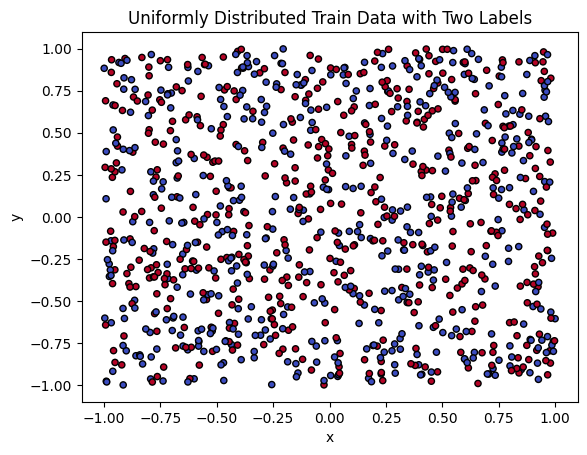

In [10]:
import torch
from sklearn.datasets import make_moons
import numpy as np
from tqdm import tqdm

# Example 4: Classification with MLP (instead of KAN)

import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
dtype = torch.get_default_dtype()


torch.manual_seed(0)
np.random.seed(0)

# Create uniformly distributed train and test datasets with two labels
rng = np.random.RandomState(0)
n_samples = 1000
bounds = (-1,1)

# Train data
train_input = rng.uniform(low=bounds[0], high=bounds[1], size=(n_samples, 2))
train_label = rng.randint(0, 2, size=n_samples)

# Test data
test_input = rng.uniform(low=bounds[0], high=bounds[1], size=(n_samples, 2))
test_label = rng.randint(0, 2, size=n_samples)

dataset = {}
dataset['train_input'] = torch.from_numpy(train_input).type(dtype).to(device)
dataset['test_input'] = torch.from_numpy(test_input).type(dtype).to(device)
dataset['train_label'] = torch.from_numpy(train_label).type(torch.long).to(device)
dataset['test_label'] = torch.from_numpy(test_label).type(torch.long).to(device)

X = dataset['train_input']
y = dataset['train_label']

plt.scatter(train_input[:, 0], train_input[:, 1], c=train_label, cmap='coolwarm', edgecolor='k', s=20)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Uniformly Distributed Train Data with Two Labels')
plt.show()


In [11]:
from scipy.ndimage import label
from skimage import measure

# Train both MLP (ReLUMLP) and KAN (SimpleKAN), then apply expressiveness measures

mlp = ReLUMLP(n_hidden=32).to(device)
kan = SimpleKAN(n_hidden=32, n_knots=16).to(device)

def train_model(model, X, y, epochs=100, lr=1e-2):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.BCEWithLogitsLoss()
    y_float = y.float().unsqueeze(1)
    for _ in tqdm(range(epochs), desc=f"Training {model.__class__.__name__}"):
        optimizer.zero_grad()
        out = model(X)
        loss = loss_fn(out, y_float)
        loss.backward()
        optimizer.step()

train_model(mlp, X, y, epochs=100, lr=1e-2)
train_model(kan, X, y, epochs=100, lr=1e-2)

# Prepare grid for boundary analysis
xx, yy = np.meshgrid(np.linspace(bounds[0], bounds[1], 200), np.linspace(bounds[0], bounds[1], 200))
grid = np.stack([xx.ravel(), yy.ravel()], axis=1)
grid_torch = torch.from_numpy(grid).type(dtype).to(device)

def get_pred(model, grid_torch):
    model.eval()
    with torch.no_grad():
        logits = model(grid_torch)
        pred = torch.sigmoid(logits).cpu().numpy().reshape(xx.shape)
    return pred

mlp_pred = get_pred(mlp, grid_torch)
kan_pred = get_pred(kan, grid_torch)



Training SimpleKAN:   0%|          | 0/100 [00:00<?, ?it/s]

Training SimpleKAN: 100%|██████████| 100/100 [00:08<00:00, 12.01it/s]


In [12]:
# Compute train accuracy for MLP
mlp.eval()
with torch.no_grad():
    mlp_logits = mlp(X)
    mlp_pred_train = (torch.sigmoid(mlp_logits).squeeze() > 0.5).long()
    mlp_acc = (mlp_pred_train == y).float().mean().item()

# Compute train accuracy for KAN
kan.eval()
with torch.no_grad():
    kan_logits = kan(X)
    kan_pred_train = (torch.sigmoid(kan_logits).squeeze() > 0.5).long()
    kan_acc = (kan_pred_train == y).float().mean().item()

print(f"MLP train accuracy: {mlp_acc:.4f}")
print(f"KAN train accuracy: {kan_acc:.4f}")

MLP train accuracy: 0.5800
KAN train accuracy: 0.7240


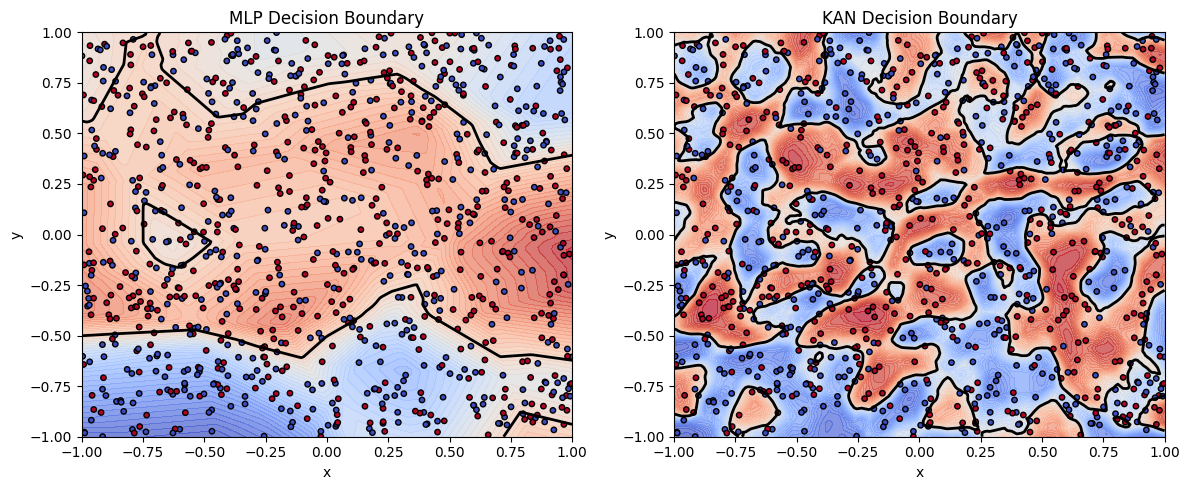

In [13]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot for MLP
axs[0].contourf(xx, yy, mlp_pred, levels=50, cmap='coolwarm', alpha=0.7)
axs[0].contour(xx, yy, mlp_pred, levels=[0.5], colors='k', linewidths=2)
axs[0].scatter(X[:, 0].cpu(), X[:, 1].cpu(), c=y.cpu(), cmap='coolwarm', edgecolor='k', s=15)
axs[0].set_title('MLP Decision Boundary')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')

# Plot for KAN
axs[1].contourf(xx, yy, kan_pred, levels=50, cmap='coolwarm', alpha=0.7)
axs[1].contour(xx, yy, kan_pred, levels=[0.5], colors='k', linewidths=2)
axs[1].scatter(X[:, 0].cpu(), X[:, 1].cpu(), c=y.cpu(), cmap='coolwarm', edgecolor='k', s=15)
axs[1].set_title('KAN Decision Boundary')
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')

plt.tight_layout()
plt.show()

In [14]:
# 1. Count linear regions (approximate by counting contiguous regions in prediction)

def count_regions(pred):
    binary = (pred > 0.5).astype(int)
    labeled, n = label(binary)
    return n

mlp_regions = count_regions(mlp_pred)
kan_regions = count_regions(kan_pred)

# 2. Decision boundary length

def boundary_length(pred):
    contours = measure.find_contours(pred, 0.5)
    total_length = sum(np.sum(np.sqrt(np.sum(np.diff(c, axis=0)**2, axis=1))) for c in contours)
    return total_length

mlp_length = boundary_length(mlp_pred)
kan_length = boundary_length(kan_pred)

# 3. Curvature (approximate: sum of angle changes along boundary)
def boundary_curvature(pred):
    contours = measure.find_contours(pred, 0.5)
    total_curvature = 0
    for c in contours:
        if len(c) < 3:
            continue
        v = np.diff(c, axis=0)
        angles = np.arctan2(v[:,1], v[:,0])
        dtheta = np.diff(angles)
        dtheta = (dtheta + np.pi) % (2 * np.pi) - np.pi
        total_curvature += np.sum(np.abs(dtheta))
    return total_curvature

mlp_curvature = boundary_curvature(mlp_pred)
kan_curvature = boundary_curvature(kan_pred)

# 4. Fractal dimension (box counting)
def fractal_dimension(pred, threshold=0.5):
    binary = (pred > threshold).astype(np.uint8)
    sizes = 2**np.arange(1, 7)
    counts = []
    for size in sizes:
        S = binary.shape[0] // size
        count = 0
        for i in range(S):
            for j in range(S):
                patch = binary[i*size:(i+1)*size, j*size:(j+1)*size]
                if np.any(patch) and not np.all(patch):
                    count += 1
        counts.append(count)
    coeffs = np.polyfit(np.log(sizes), np.log(counts), 1)
    return -coeffs[0]

mlp_fractal = fractal_dimension(mlp_pred)
kan_fractal = fractal_dimension(kan_pred)

# Print results
print("Method                | MLP         | KAN")
print("----------------------|-------------|-------------")
print(f"Linear regions        | {mlp_regions:<11} | {kan_regions:<11}")
print(f"Boundary length       | {mlp_length:.2f}      | {kan_length:.2f}")
print(f"Curvature             | {mlp_curvature:.2f}      | {kan_curvature:.2f}")
print(f"Fractal dimension     | {mlp_fractal:.2f}      | {kan_fractal:.2f}")

Method                | MLP         | KAN
----------------------|-------------|-------------
Linear regions        | 2           | 15         
Boundary length       | 636.53      | 2938.44
Curvature             | 27.59      | 577.05
Fractal dimension     | 0.92      | 1.37


In [15]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"MLP parameter count: {count_parameters(mlp)}")
print(f"KAN parameter count: {count_parameters(kan)}")

MLP parameter count: 1185
KAN parameter count: 2209


Training ReLUMLP:   0%|          | 0/100 [00:00<?, ?it/s]

Training SimpleKAN: 100%|██████████| 100/100 [04:36<00:00,  2.76s/it]


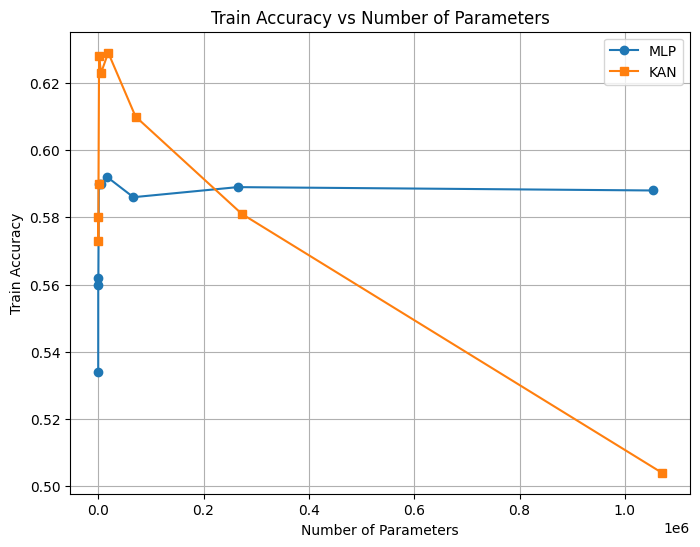

In [16]:
mlp_accs = []
kan_accs = []
mlp_params = []
kan_params = []

hidden_sizes = [4, 8, 16, 32, 64, 128, 256, 512, 1024]
#n_knots_list = [8, 16, 32]
n_knots_list = [8]

for n_hidden in hidden_sizes:
    # MLP
    mlp = ReLUMLP(n_hidden=n_hidden).to(device)
    train_model(mlp, X, y, epochs=100, lr=1e-2)
    mlp.eval()
    with torch.no_grad():
        logits = mlp(X)
        pred_train = (torch.sigmoid(logits).squeeze() > 0.5).long()
        acc = (pred_train == y).float().mean().item()
    mlp_accs.append(acc)
    mlp_params.append(count_parameters(mlp))

for n_hidden in hidden_sizes:
    for n_knots in n_knots_list:
        kan = SimpleKAN(n_hidden=n_hidden, n_knots=n_knots).to(device)
        train_model(kan, X, y, epochs=100, lr=1e-2)
        kan.eval()
        with torch.no_grad():
            logits = kan(X)
            pred_train = (torch.sigmoid(logits).squeeze() > 0.5).long()
            acc = (pred_train == y).float().mean().item()
        kan_accs.append(acc)
        kan_params.append(count_parameters(kan))

plt.figure(figsize=(8,6))
plt.plot(mlp_params, mlp_accs, 'o-', label='MLP')
plt.plot(kan_params, kan_accs, 's-', label='KAN')
plt.xlabel('Number of Parameters')
plt.ylabel('Train Accuracy')
plt.title('Train Accuracy vs Number of Parameters')
plt.legend()
plt.grid(True)
plt.show()